# Transit Modelling Workbook  
  
  - ~~set up to read in TESS_SC~~
  - add option to clean up local cache for FITS downloads
  - ~~read in TIC stellar parameters~~
  - ~~limb-darkening prior~~
  - ~~set up initial transit model~~
  - ~~transit plot~~
  - detrend data set
  - initial transit
  - likelihood model
  - MCMC
  - transit model table
  
  
### How to setup detrend5

in the utils directory run:

`f2py3 -c detrend5.pyf polyfilter_ramp.f rqsort.f gaussj.f stdev.f --fcompiler=intelem`

If you are using gfortran remove the --fcompiler=intelem flag

### How to setup tfit5 module

in the utils directory run:

`f2py3 -c tfit5.pyf transitmodel.f keplerian.f ttcor.f occultquad.f mandelagol.f rqsort.f transitdur.f -lpthread -liomp5 --fcompiler=intelem --f90flags='-parallel -mkl -qopenmp' --f77flags='-parallel -mkl -qopenmp'`

In [1]:
import sys
sys.path.insert(0, "./utils/")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

#Fortran based fancy detrender. It's a bit slow, because it does automagic gap detection.
#However it's about 100x faster than its python equivilent.
import detrend5 

In [2]:
import autotransit as au

## Notebook parameters

In [3]:
toi_file="TOI_2020.09.08_14.21.51.csv" #nexsci catalogue for TOI parameters 

toi=2143.01 #The TOI we want to work with.

detrend_win=2.0 #Detrending Window [days]

In [4]:
def detrend(phot,detrend_win,nfitp=4,nc=20,itime=0.02083):
    """Wrapper for Fortran based detrender.
    
    phot = (phot.class) 
        phot.time = time stamps (np.array) [days]
        phot.flux = relative flux (np.array)
    detrend_win = detrend window (np.float) [days]
    
    nfitp = polynomial order (int) 
    nc = cadence gap detection (int).  nc*itime gives the window size for gap detection
    itime = integration time (np.float) [days]
    
    """
    
    npt=len(phot.time)
    ts=np.zeros(npt,dtype=int)
    tflag=np.zeros(npt,dtype=int) #for marking transits
    boxbin=np.copy(detrend_win)
    x=np.zeros(npt) #work arrays
    y=np.zeros(npt)
    z=np.zeros(npt)
    ngap=0
    gaps=np.zeros(npt)
    offset=np.zeros(npt)
    work=np.zeros(npt)
    
    phot_d=au.phot_class()
    phot_d.time=np.copy(phot.time)
    phot_d.flux=np.copy(phot.flux)
    phot_d.ferr=np.copy(phot.ferr)
    phot_d.itime=np.copy(phot.itime)
    
    detrend5.polyfilter(phot_d.time,phot_d.flux,phot_d.ferr,ts,tflag,boxbin,x,y,z,ngap,gaps,\
                        offset,nfitp,work,nc,itime)
    
    return phot_d

## readtoicsv  
  
  This routine reads in a CSV file as downloaded from NexSCI (is there an API for this?)  
    
  The following values are stored in exocat_class

    exocat.ticid = TIC ID (int) 
    exocat.toiid = TOI ID (float)  
    exocat.toiid_str = TIC ID (string)
    exocat.ra = RA (float)
    exocat.dec = DEC (float)
    exocat.tmag = TESS mag (float)
    exocat.t0 = Centre of transit time (float) [days]
    exocat.t0err = uncertainity on t0 [days]
    exocat.per = orbital period (float) [days]
    exocat.pererr = uncertainity of per (float) [days]
    exocat.tdur = transit duration (float) [days]
    exocat.tdurerr = errors on tdur (float) [days]
    exocat.tdep = transit depth (float) [ppm]
    exocat.tdeperr = error on tdep (float) [ppm]


In [5]:
exocat=au.readtoicsv(toi_file)

## Fetch SC TESS Lightcurve

Using MAST API, pull down FITS files.  They are cached locally in 'download'.  

astropy is used to open up the FITS files and retrieve time, phot, phot error.  We are assuming 2-minute cadence for SC MAST data.  The lightcurve is returned in phot_class

The following values are stored in phot_class  

    phot.time = time stamps (np.array) [days]
    phot.flux = relative flux (np.array) 
    phot.ferr = reported uncertainity in phot.flux (np.array)
    phot.itime = integration time (np.array) [days]

In [6]:
toi=2143.01
toi_index = [j for j, x in enumerate(exocat.toiid) if x == toi][0]
print('TIC ID: ',exocat.ticid[toi_index],'| TOI ID: ',exocat.toiid[toi_index])

#Get SC Lightcurve for MAST

#Each Sector/Quarter of data is median corrected independently, then concatentated together.
phot_SC=au.get_tess_data(exocat.ticid[toi_index])  #give the TIC_ID and return SC data.

TIC ID:  103195323 | TOI ID:  2143.01
INFO: Found cached file ./download/mastDownload/TESS/tess2020133194932-s0025-0000000103195323-0182-s/tess2020133194932-s0025-0000000103195323-0182-s_lc.fits with expected size 1877760. [astroquery.query]
INFO: Found cached file ./download/mastDownload/TESS/tess2020160202036-s0026-0000000103195323-0188-s/tess2020160202036-s0026-0000000103195323-0188-s_lc.fits with expected size 1820160. [astroquery.query]
./download/mastDownload/TESS/tess2020133194932-s0025-0000000103195323-0182-s/tess2020133194932-s0025-0000000103195323-0182-s_lc.fits
./download/mastDownload/TESS/tess2020160202036-s0026-0000000103195323-0188-s/tess2020160202036-s0026-0000000103195323-0188-s_lc.fits


## Make a quick plot of the raw-lightcurve phased at the reported orbital period

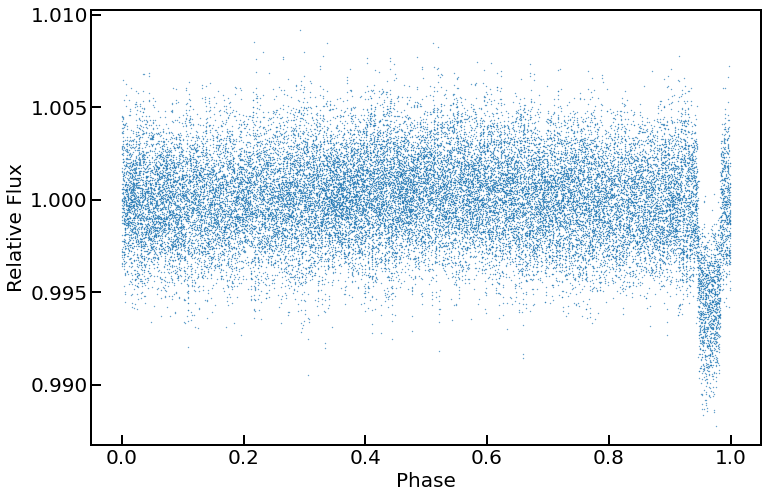

In [7]:
per=exocat.per[toi_index]

matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
plt.figure(figsize=(12,8)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', length=10, width=2)
ax.scatter(phot_SC.time/per-np.floor(phot_SC.time/per),phot_SC.flux,s=0.1)
ax.set_xlabel('Phase')
ax.set_ylabel('Relative Flux')

plt.show()

## Get stellar parameters  

These are pulled using MAST API for the TIC.  

Results are stored in starpars_class()

    starpars.rhostar = mean stellar density (np.float) [cgs]
    starpars.rhostar_err = error on rhostar (np.float) [cgs]
    starpars.teff = stellar effective temperature (np.float) [K]
    starpars.teff_err = error on teff (np.float) [K]
    starpars.logg = log surface gravity (np.float) [cgs]
    starpars.logg_err = error on logg
    starpars.feh = metallicity (np.float) [Fe/H]
    starpars.feh_err = error on feh

In [8]:
#Get Stellar parameters from MAST
tic_output=au.ticAdvancedSearch(exocat.ticid[toi_index])

#Store stellar parameters in class.
starpars=au.starpars_class()
starpars.rhostar=tic_output['data'][0]['rho'] #CGS units
starpars.rhostar_err=tic_output['data'][0]['e_rho']
starpars.teff=tic_output['data'][0]['Teff']
starpars.teff_err=tic_output['data'][0]['e_Teff']
starpars.logg=tic_output['data'][0]['logg']
starpars.logg_err=tic_output['data'][0]['e_logg']
starpars.feh=tic_output['data'][0]['MH']
starpars.feh_err=tic_output['data'][0]['e_MH']
if starpars.feh==None:
    starpars.feh=0.0
    starpars.feh_err=1.0
print(starpars.teff,starpars.logg,starpars.feh)

7437 4.0884 0.0


## Get limb-darkening and priors

This is currently a hack that uses a commandline parameter. I need to pull the subroutine and build a wrapper to have the get_limb_q1q2() function work natively. 

In [9]:
#Example to get limb-darkening from Claret tables for the TESS bandpass given Teff, logg, [FeH]
q1,q2=au.get_limb_q1q2(starpars.teff,starpars.logg,starpars.feh)
print(q1,q2)

0.232115822656 0.15103033724656692


In [10]:
#Example to get priors.  The routine gets 100 samples and calculates standard deviation.
starpars.q1,starpars.q2,starpars.q1_err,starpars.q2_err=au.limbprior(starpars)
print(starpars.q1,starpars.q2,starpars.q1_err,starpars.q2_err)

0.232115822656 0.15103033724656692 0.011102086400560639 0.026291240825171126


## Set up initial model based on parameters from Nexsci table.  

The tables at NEXSCI are lacking, since they only report tdepth and tdur opposed to impact parameter and a/R* or rhostar.  This means we are guessing at a solution.  This fails when b>0.9. 

In [11]:
sol,serr=au.build_initial_sol(starpars,exocat,toi_index)
print(sol)

[0.229233, 0.0, 0.0, 0.232115822656, 0.15103033724656692, 0.0, 0.0, 0.0, 2012.0160179999657, 5.589479, 0.4, 0.07822658601140663, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


## Make a plot of our initial solution

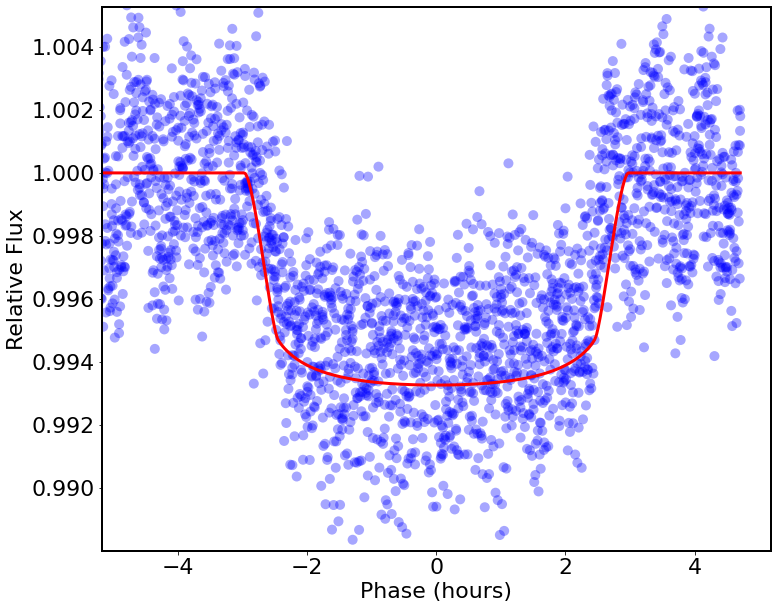

In [12]:
au.transitplot(phot_SC.time,phot_SC.flux,sol,itime=phot_SC.itime)

## Flag in-transit data to be used by the detrender

In [12]:
phot=detrend(phot_SC,detrend_win)

NameError: name 'phot' is not defined

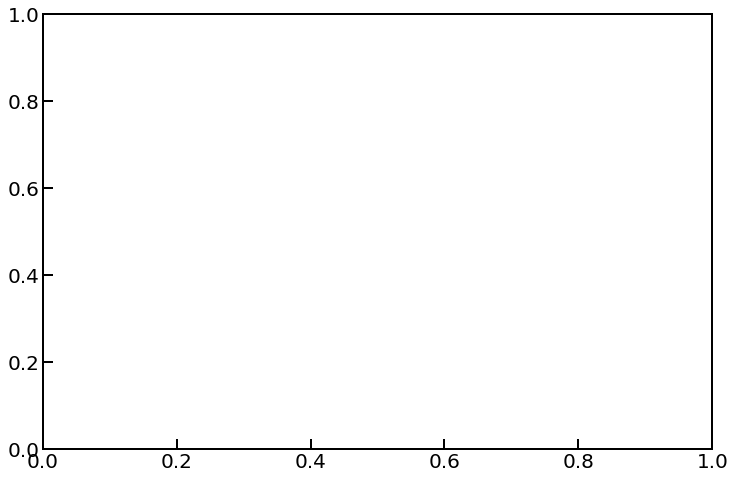

In [16]:
## Plotting stuff that can be removed
per=exocat.per[i]
matplotlib.rcParams.update({'font.size': 20}) #adjust font
matplotlib.rcParams['axes.linewidth'] = 2.0
plt.figure(figsize=(12,8)) #adjust size of figure
ax = plt.axes()
ax.tick_params(direction='in', length=10, width=2)
ax.scatter(phot.time/per-np.floor(phot.time/per),phot.flux,s=0.1)
ax.set_xlabel('Phase')
ax.set_ylabel('Relative Flux')

plt.show()